In [1]:
import numpy as np
import pandas as pd 
import os
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import seaborn as sns
import gzip

In [2]:
train= pd.read_csv('train_ad-Prediction.gz',nrows=3000)
test =pd.read_csv('test_adPrediction.gz',nrows=3000)

In [3]:
df = pd.concat([train,test]).drop(['id'], axis=1)

In [4]:
df.head(5)

,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,0.0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,...,1,2,15706,320,50,1722,0,35,-1,79
1,0.0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,...,1,0,15704,320,50,1722,0,35,100084,79
2,0.0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,...,1,0,15704,320,50,1722,0,35,100084,79
3,0.0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,...,1,0,15706,320,50,1722,0,35,100084,79
4,0.0,14102100,1005,1,fe8cc448,9166c161,0569f928,ecad2386,7801e8d9,07d7df22,...,1,0,18993,320,50,2161,0,35,-1,157


In [5]:
df.tail(5)

,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
2995,NaN,14103100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,...,1,0,22676,320,50,2616,0,35,-1,51
2996,NaN,14103100,1012,1,c52338a7,c4e18dd6,dedf689d,ecad2386,7801e8d9,07d7df22,...,1,0,23722,320,50,2716,3,47,-1,23
2997,NaN,14103100,1005,0,85f751fd,c4e18dd6,50e219e0,3c4b944d,2347f47a,0f2161f8,...,1,2,18987,320,50,2158,3,291,-1,61
2998,NaN,14103100,1005,1,85f751fd,c4e18dd6,50e219e0,cf0327f9,2347f47a,0f2161f8,...,1,0,23646,300,50,2709,3,39,100013,23
2999,NaN,14103100,1005,0,85f751fd,c4e18dd6,50e219e0,08b5f605,33da2e74,dc97ec06,...,1,0,20153,320,50,2307,3,163,100020,61


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6000 entries, 0 to 2999
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   click             3000 non-null   float64
 1   hour              6000 non-null   int64  
 2   C1                6000 non-null   int64  
 3   banner_pos        6000 non-null   int64  
 4   site_id           6000 non-null   object 
 5   site_domain       6000 non-null   object 
 6   site_category     6000 non-null   object 
 7   app_id            6000 non-null   object 
 8   app_domain        6000 non-null   object 
 9   app_category      6000 non-null   object 
 10  device_id         6000 non-null   object 
 11  device_ip         6000 non-null   object 
 12  device_model      6000 non-null   object 
 13  device_type       6000 non-null   int64  
 14  device_conn_type  6000 non-null   int64  
 15  C14               6000 non-null   int64  
 16  C15               6000 non-null   int64  


In [7]:
df.columns

Index(['click', 'hour', 'C1', 'banner_pos', 'site_id', 'site_domain',
       'site_category', 'app_id', 'app_domain', 'app_category', 'device_id',
       'device_ip', 'device_model', 'device_type', 'device_conn_type', 'C14',
       'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21'],
      dtype='object')

In [8]:
df.isnull().sum()

click               3000
hour                   0
C1                     0
banner_pos             0
site_id                0
site_domain            0
site_category          0
app_id                 0
app_domain             0
app_category           0
device_id              0
device_ip              0
device_model           0
device_type            0
device_conn_type       0
C14                    0
C15                    0
C16                    0
C17                    0
C18                    0
C19                    0
C20                    0
C21                    0
dtype: int64

In [9]:
df.describe()

,click,hour,C1,banner_pos,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
count,3000.000000,6.000000e+03,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000
mean,0.164000,1.410260e+07,1005.029833,0.183167,1.025667,0.300333,19397.441500,318.823333,58.581333,2181.862500,0.991000,157.244000,45533.459667,94.844833
std,0.370337,5.000417e+02,1.029621,0.432798,0.469444,0.796600,3916.784501,13.299709,41.859138,490.118661,1.314866,251.133656,49855.720418,69.636920
min,0.000000,1.410210e+07,1001.000000,0.000000,0.000000,0.000000,375.000000,216.000000,36.000000,112.000000,0.000000,33.000000,-1.000000,13.000000
25%,0.000000,1.410210e+07,1005.000000,0.000000,1.000000,0.000000,15708.000000,320.000000,50.000000,1722.000000,0.000000,35.000000,-1.000000,46.000000
50%,0.000000,1.410260e+07,1005.000000,0.000000,1.000000,0.000000,20362.000000,320.000000,50.000000,2307.000000,0.000000,39.000000,-1.000000,79.000000
75%,0.000000,1.410310e+07,1005.000000,0.000000,1.000000,0.000000,22676.000000,320.000000,50.000000,2616.000000,2.000000,167.000000,100084.000000,157.000000
max,1.000000,1.410310e+07,1012.000000,7.000000,5.000000,5.000000,24043.000000,728.000000,480.000000,2757.000000,3.000000,1835.000000,100248.000000,253.000000


In [10]:
df.duplicated()

0       False
1       False
2       False
3       False
4       False
        ...  
2995    False
2996     True
2997     True
2998     True
2999    False
Length: 6000, dtype: bool

In [11]:
def get_date(hour):
    y = '20'+str(hour)[:2]
    m = str(hour)[2:4]
    d = str(hour)[4:6]
    return y+'-'+m+'-'+d

df['weekday'] = pd.to_datetime(df.hour.apply(get_date)).dt.dayofweek.astype(str)

def tran_hour(x):
    x = x % 100
    while x in [23,0]:
        return '23-01'
    while x in [1,2]:
        return '01-03'
    while x in [3,4]:
        return '03-05'
    while x in [5,6]:
        return '05-07'
    while x in [7,8]:
        return '07-09'
    while x in [9,10]:
        return '09-11'
    while x in [11,12]:
        return '11-13'
    while x in [13,14]:
        return '13-15'
    while x in [15,16]:
        return '15-17'
    while x in [17,18]:
        return '17-19'
    while x in [19,20]:
        return '19-21'
    while x in [21,22]:
        return '21-23'

df['hour'] = df.hour.apply(tran_hour)

In [12]:
len_of_feature_count = []
for i in df.columns[2:23].tolist():
    print(i, ':', len(df[i].astype(str).value_counts()))
    len_of_feature_count.append(len(df[i].astype(str).value_counts()))

C1 : 6
banner_pos : 5
site_id : 314
site_domain : 261
site_category : 15
app_id : 249
app_domain : 27
app_category : 11
device_id : 742
device_ip : 5038
device_model : 973
device_type : 4
device_conn_type : 4
C14 : 423
C15 : 5
C16 : 6
C17 : 164
C18 : 4
C19 : 45
C20 : 101
C21 : 34


In [13]:
need_tran_feature = df.columns[2:4].tolist() + df.columns[13:23].tolist()

for i in need_tran_feature:
    df[i] = df[i].astype(str)

In [14]:
obj_features = []

for i in range(len(len_of_feature_count)):
    if len_of_feature_count[i] > 10:
        obj_features.append(df.columns[2:23].tolist()[i])
obj_features

['site_id',
 'site_domain',
 'site_category',
 'app_id',
 'app_domain',
 'app_category',
 'device_id',
 'device_ip',
 'device_model',
 'C14',
 'C17',
 'C19',
 'C20',
 'C21']

In [15]:
df_describe = df.describe()
df_describe

,click
count,3000.000000
mean,0.164000
std,0.370337
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [16]:
df_describe = df.describe()

In [17]:
def obj_clean(X):
    def get_click_rate(x):
        temp = train[train[X.columns[0]] == x]
        res = round((temp.click.sum() / temp.click.count()), 3)
        return res

    def get_type(V, val):
        very_high = val + 0.04
        higher = val + 0.02
        lower = val - 0.02
        very_low = val - 0.04

        vh_type = V[V > very_high].index.tolist()
        hr_type = V[(V > higher) & (V < very_high)].index.tolist()
        vl_type = V[V < very_low].index.tolist()
        lr_type = V[(V < lower) & (V > very_low)].index.tolist()
        return vh_type, hr_type, vl_type, lr_type

    def clean_function(x):
        if x in type_[0]:
            return 'very_high'
        elif x in type_[1]:
            return 'higher'
        elif x in type_[2]:
            return 'very_low'
        elif x in type_[3]:
            return 'lower'
        else:
            return 'mid'

    print('Run:', X.columns[0])
    fq = X[X.columns[0]].value_counts()

    if len(fq) > 3000:
        fq = fq[:3000]

    fq = pd.DataFrame(fq)
    fq['new_column'] = fq.index
    fq['click_rate'] = fq.new_column.apply(get_click_rate)
    type_ = get_type(fq['click_rate'], df_describe.loc['mean', 'click'])
    return X[X.columns[0]].apply(clean_function)

for i in obj_features:
    df[i] = obj_clean(df[[i]])

df

Run: site_id
Run: site_domain
Run: site_category
Run: app_id
Run: app_domain
Run: app_category
Run: device_id
Run: device_ip
Run: device_model
Run: C14
Run: C17
Run: C19
Run: C20
Run: C21


,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,...,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21,weekday
0,0.0,23-01,1005,0,higher,higher,higher,mid,mid,mid,...,2,mid,320,50,mid,0,mid,mid,mid,1
1,0.0,23-01,1005,0,higher,higher,higher,mid,mid,mid,...,0,mid,320,50,mid,0,mid,mid,mid,1
2,0.0,23-01,1005,0,higher,higher,higher,mid,mid,mid,...,0,mid,320,50,mid,0,mid,mid,mid,1
3,0.0,23-01,1005,0,higher,higher,higher,mid,mid,mid,...,0,mid,320,50,mid,0,mid,mid,mid,1
4,0.0,23-01,1005,1,very_low,very_low,very_low,mid,mid,mid,...,0,mid,320,50,mid,0,mid,mid,mid,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,NaN,23-01,1005,0,higher,higher,higher,mid,mid,mid,...,0,mid,320,50,mid,0,mid,mid,mid,4
2996,NaN,23-01,1012,1,mid,very_low,mid,mid,mid,mid,...,0,mid,320,50,mid,3,mid,mid,mid,4
2997,NaN,23-01,1005,0,very_low,very_low,very_low,higher,very_low,very_low,...,2,mid,320,50,mid,3,mid,mid,mid,4
2998,NaN,23-01,1005,1,very_low,very_low,very_low,mid,very_low,very_low,...,0,mid,300,50,mid,3,mid,mid,mid,4


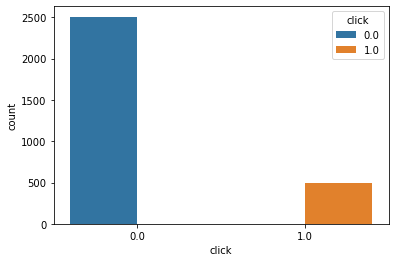

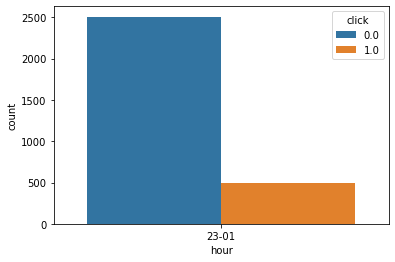

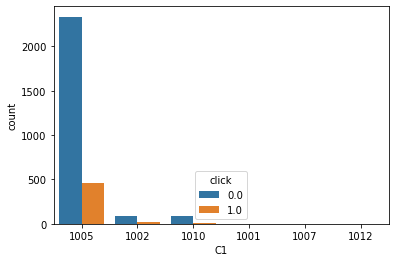

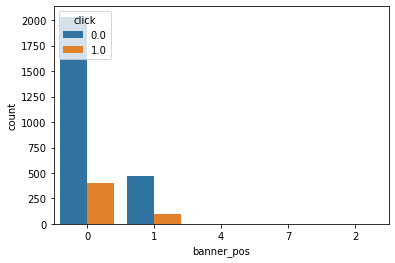

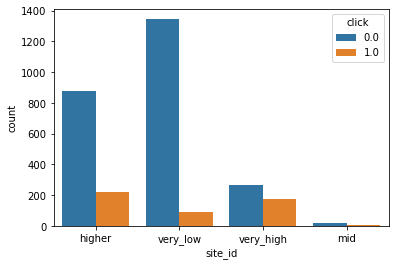

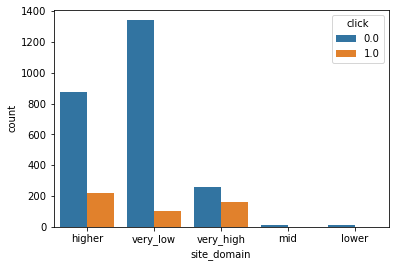

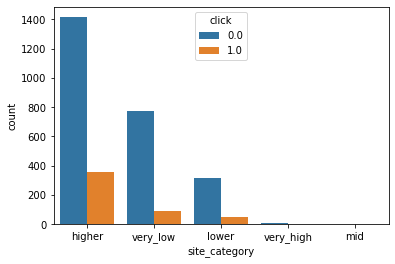

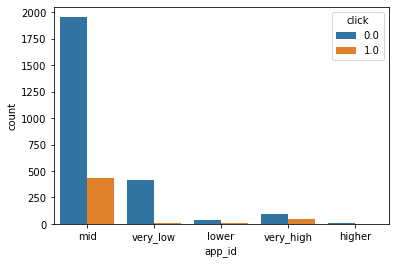

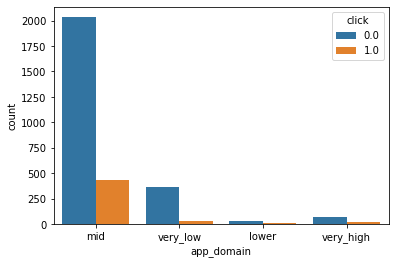

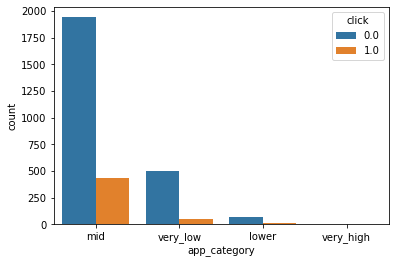

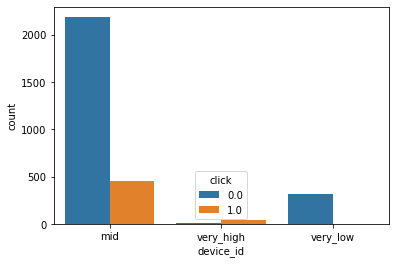

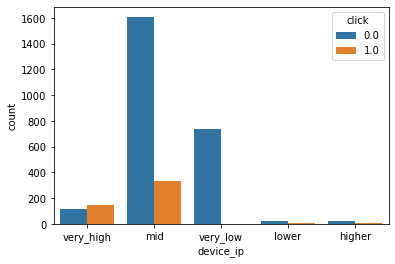

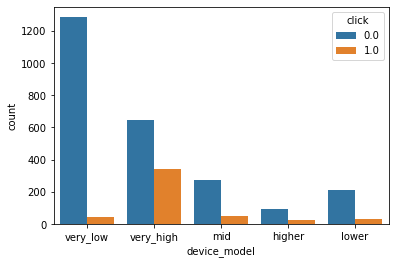

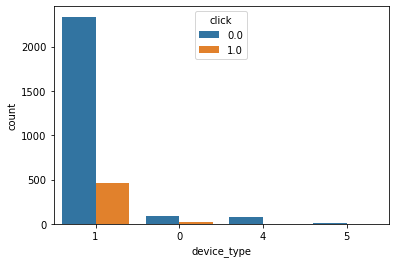

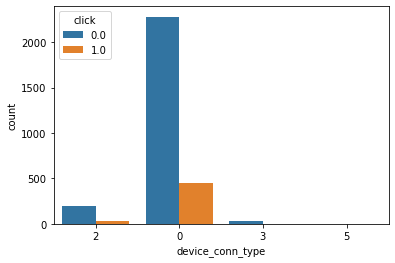

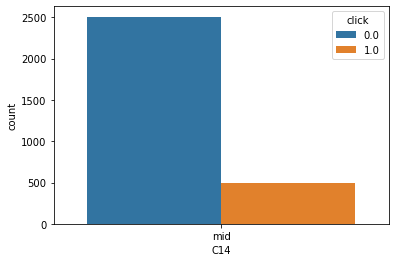

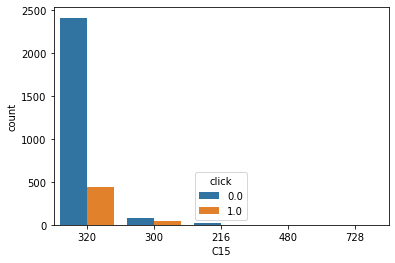

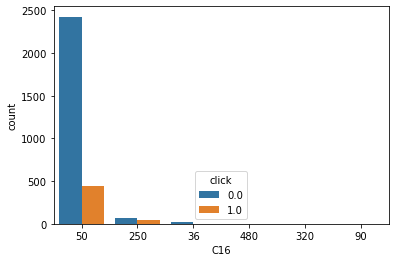

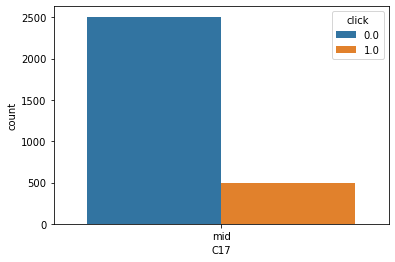

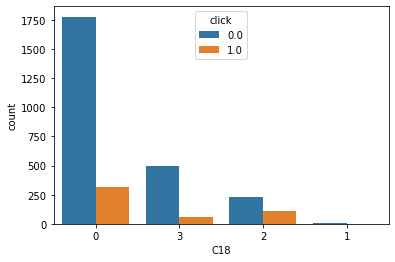

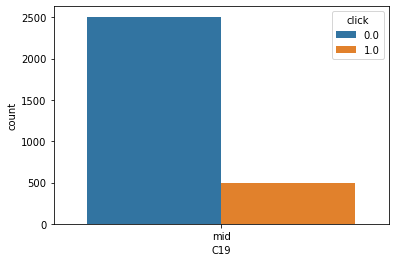

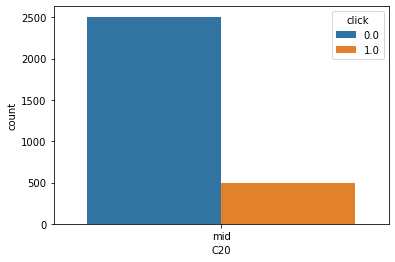

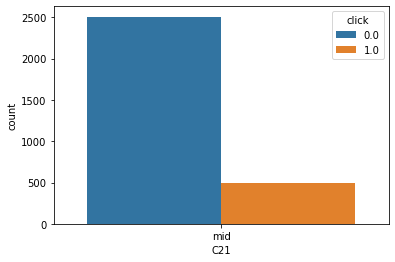

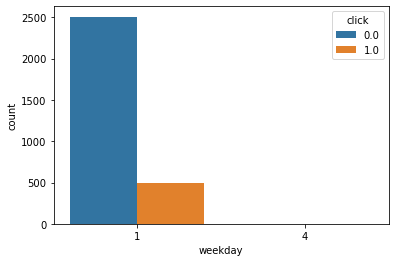

In [18]:
for i in df.columns:
    sns.countplot(x = i, hue = "click", data = df)
    plt.show()

In [19]:
df.drop(['device_id', 'C14', 'C17', 'C19', 'C20', 'C21'], axis=1, inplace=True)

In [20]:
#df = pd.get_dummies(df)

In [21]:
train.reset_index(inplace=True)
train_len = len(train)
train_len

3000

In [22]:
df = pd.get_dummies(df)
train = df[:train_len]
test = df[train_len:]

In [23]:
pre_X = train[train['click'] == 0].sample(n=len(train[train['click'] == 1]), random_state=111)
pre_X = pd.concat([pre_X, train[train['click'] == 1]]).sample(frac=1)
pre_y = pre_X[['click']]
pre_X.drop(['click'], axis=1, inplace=True)
test.drop(['click'], axis=1, inplace=True)

C:\Users\Lagartha Lothbroke\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [24]:
pre_X_train, pre_X_test, pre_y_train, pre_y_test = train_test_split(pre_X, pre_y, test_size=0.20, stratify=pre_y, random_state=1)

In [25]:
params = {"criterion":["gini", "entropy"], "max_depth":range(1,20)}
grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid=params, scoring='roc_auc', cv=100, verbose=1, n_jobs=-1)
grid_search.fit(pre_X_train, pre_y_train)
grid_search.best_score_, grid_search.best_estimator_, grid_search.best_params_

Fitting 100 folds for each of 38 candidates, totalling 3800 fits


(0.8733333333333333,
 DecisionTreeClassifier(criterion='entropy', max_depth=5),
 {'criterion': 'entropy', 'max_depth': 5})

In [26]:
tree = grid_search.best_estimator_
tree.fit(pre_X,pre_y)

feature_importances = pd.DataFrame(tree.feature_importances_)
feature_importances.index = pre_X_train.columns
feature_importances = feature_importances.sort_values(0,ascending=False)
feature_importances

,0
device_model_very_low,0.377809
device_ip_very_low,0.265988
device_ip_very_high,0.095566
site_id_very_high,0.082711
site_id_very_low,0.051113
...,...
app_domain_very_high,0.000000
app_category_lower,0.000000
app_category_mid,0.000000
C1_1001,0.000000


In [27]:
pre_X_train = pre_X_train[feature_importances.index[:int(len(feature_importances)/3)]]
pre_X_test = pre_X_test[feature_importances.index[:int(len(feature_importances)/3)]]

In [28]:
params = {"criterion":["gini", "entropy"], "max_depth":range(1,12)}
grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid=params, scoring='roc_auc', cv=100, verbose=1, n_jobs=-1)
grid_search.fit(pre_X_train, pre_y_train)
grid_search.best_score_, grid_search.best_estimator_, grid_search.best_params_

Fitting 100 folds for each of 22 candidates, totalling 2200 fits


(0.8847916666666668,
 DecisionTreeClassifier(criterion='entropy', max_depth=5),
 {'criterion': 'entropy', 'max_depth': 5})

In [29]:
pre_X = pre_X[feature_importances.index[:int(len(feature_importances)/3)]]

tree = grid_search.best_estimator_
tree.fit(pre_X,pre_y)
feature_importances = pd.DataFrame(tree.feature_importances_)
feature_importances.index = pre_X_train.columns
feature_importances = feature_importances.sort_values(0,ascending=False)
feature_importances

,0
device_model_very_low,0.377809
device_ip_very_low,0.272529
device_ip_very_high,0.095566
site_id_very_high,0.087891
site_id_very_low,0.051113
device_model_very_high,0.043831
device_model_lower,0.022622
banner_pos_0,0.019810
C18_2,0.007661
device_model_higher,0.007534


In [30]:
feature_len = len(feature_importances[feature_importances[feature_importances.columns[0]] > 0.005])

y = train[['click']]
X = train[feature_importances[:feature_len].index]
test = test[feature_importances[:feature_len].index]

In [31]:
import xgboost as xgb
from sklearn.metrics import roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

[11:03:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

ROC AUC Score: 91.30019709288003 %


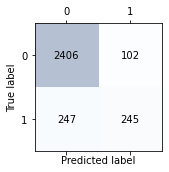

In [32]:
y_np = np.array(y) # Convert the target variable to a numpy array
dtrain = xgb.DMatrix(X, label=y_np)# Create an XGBoost DMatrix
params = {
    'tree_method': 'hist',
    'n_jobs': -1,
    'n_estimators': 500,
    'max_depth': 11
} # Define the parameters for the XGBoost model
model = xgb.train(params, dtrain) # Train the XGBoost model
y_pred = model.predict(dtrain) # Make predictions on the training data
y_pred_binary = np.round(y_pred) # Convert the probabilities to binary predictions
roc_auc = roc_auc_score(y_np, y_pred)# Calculate and print the ROC AUC score
print("ROC AUC Score:", roc_auc * 100, "%")
confmat = confusion_matrix(y_np, y_pred_binary, labels=[0, 1]) # Create the confusion matrix
fig, ax = plt.subplots(figsize=(2.5, 2.5)) # Plot the confusion matrix
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [34]:
from sklearn.linear_model import LogisticRegression

In [35]:
model = LogisticRegression()

In [36]:
model.fit(X_train, y_train)

C:\Users\Lagartha Lothbroke\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

In [37]:
from sklearn.metrics import accuracy_score

In [38]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.86


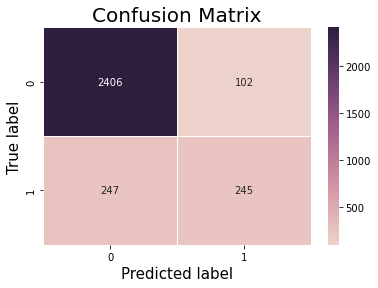

<Figure size 6000x6000 with 0 Axes>

In [39]:
import seaborn as sns
sns.heatmap(confmat,annot=True,fmt='',xticklabels=[0,1],yticklabels=[0,1],linewidth=.5, cmap=sns.cubehelix_palette(as_cmap=True))

plt.xlabel('Predicted label',fontsize=15)
plt.ylabel('True label',fontsize=15)
plt.title('Confusion Matrix',fontsize=20)
plt.figure(figsize=(30.0,30.0),dpi=200)
plt.tight_layout()
plt.show()

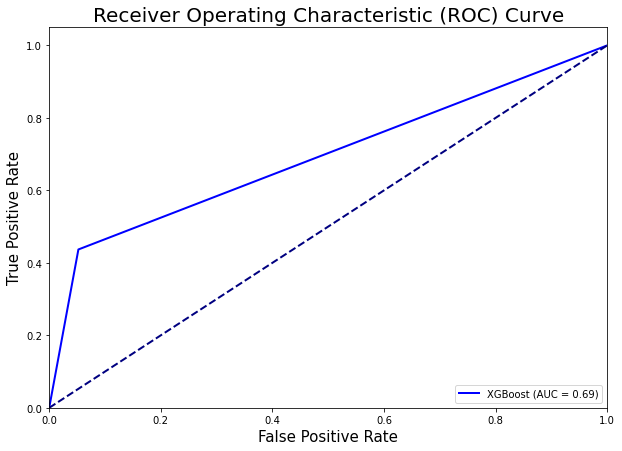

In [41]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='blue', lw=2, label='XGBoost (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=20)
plt.legend(loc="lower right")
plt.show()

In [42]:
sample_size = df.shape[0]
print("Sample size:", sample_size)

Sample size: 6000
